In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
from skimage.io import imread,imsave























### Load initial data 

In [3]:
data = glob('/input/train/*.jpg')
print data[:5]
print len(data)

['/input/train/cat.6984.jpg', '/input/train/dog.5677.jpg', '/input/train/dog.4948.jpg', '/input/train/dog.9952.jpg', '/input/train/cat.9101.jpg']
25000


### Create Sample

#### Create Sample Data

In [3]:
sample = []

shuf = np.random.permutation(data)
for i in xrange(200):
    sample.append(shuf[i])
    
print len(sample)

200


#### Create Sample Validation

In [4]:
sample_valid = []

shuf = np.random.permutation(sample)
for i in xrange(20):
    sample_valid.append(shuf[i])

sample_train = list(set(sample) - set(sample_valid))

sample_train = np.array(sample_train)
sample_valid = np.array(sample_valid)
print sample_train.shape
print sample_valid.shape

(180,)
(20,)


#### Sample Images

In [5]:
sample_img =[]
sample_labels=[]

for i in range(len(sample_train)):
    img = imread(sample_train[i])
    sample_img.append(img)
    
    if 'dog' in sample_train[i]:
        sample_labels.append([1,0])
    else:
        sample_labels.append([0,1])
        
sample_img = np.array(sample_img)
sample_labels = np.array(sample_labels)

print sample_img.shape
print sample_labels.shape

(180,)
(180, 2)


In [6]:
sample_valid_img =[]
sample_valid_labels=[]

for i in range(len(sample_valid)):
    img = imread(sample_valid[i])
    sample_valid_img.append(img)
    
    if 'dog' in sample_valid[i]:
        sample_valid_labels.append([1,0])
    else:
        sample_valid_labels.append([0,1])
        
sample_valid_img = np.array(sample_valid_img)
sample_valid_labels = np.array(sample_valid_labels)

print sample_valid_img.shape
print sample_valid_labels.shape

(20,)
(20, 2)


### Display sample

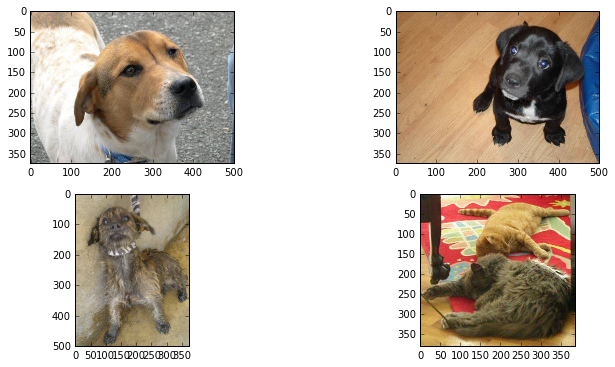

In [7]:
fig = plt.figure(figsize = (12,6))
fig.add_subplot(2,2,1)
plt.imshow(sample_img[0].astype(np.uint8))

fig.add_subplot(2,2,2)
plt.imshow(sample_img[1].astype(np.uint8))

fig.add_subplot(2,2,3)
plt.imshow(sample_img[2].astype(np.uint8))

fig.add_subplot(2,2,4)
plt.imshow(sample_img[3].astype(np.uint8))

### Create Validation

In [4]:
valid = []

shuf = np.random.permutation(data)
for i in xrange(2000):
    valid.append(shuf[i])

train = list(set(data) - set(valid))

train = np.array(train)
valid = np.array(valid)
print train.shape
print valid.shape

(23000,)
(2000,)


In [5]:
valid_img =[]
valid_labels=[]

for i in range(len(valid)):
    img = imread(valid[i])
    valid_img.append(img)
    
    if 'dog' in valid[i]:
        valid_labels.append([1,0])
    else:
        valid_labels.append([0,1])
        
valid_img = np.array(valid_img)
valid_labels = np.array(valid_labels)

print valid_img.shape
print valid_labels.shape

(2000,)
(2000, 2)


### Create Training Data

In [6]:
train_img=[]
train_labels=[]

for i in xrange(len(train)):
    img = imread(train[i])
    train_img.append(img)
    if 'dog' in train[i]:
        train_labels.append([1,0])
    else:
        train_labels.append([0,1])

In [7]:
train_img = np.array(train_img)
train_labels = np.array(train_labels)


print train_img.shape
print train_labels.shape

(23000,)
(23000, 2)


## Call Keras Model

In [11]:
from keras.applications.resnet50 import ResNet50

In [12]:
resnet = ResNet50(include_top=False, weights = 'imagenet', input_shape=(224,224,3))

In [13]:
resnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 230, 230, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

### Finetuning the VGG model

In [14]:
for layer in resnet.layers:
    layer.trainable = False

In [15]:
from keras.layers import Dense, Flatten
last = resnet.output

fc = Flatten()(last)
output = Dense(2, activation = 'softmax')(fc)

In [16]:
from keras.models import Model

model = Model(resnet.input, output)

In [17]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 230, 230, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

In [18]:
from keras.optimizers import Adam

In [19]:
model.compile(optimizer=Adam(lr=3e-4),loss='categorical_crossentropy',metrics=['accuracy'])

## Sample Preprocessing

In [34]:
from skimage.transform import resize

In [22]:
train_X = []
for i in xrange(sample_img.shape[0]):
    img = resize(sample_img[i], (224,224,3), preserve_range=True)
    train_X.append(img)
    
train_X = np.array(train_X)
print train_X.shape

(180, 224, 224, 3)


In [23]:
valid_X = []
for i in xrange(sample_valid_img.shape[0]):
    img = resize(sample_valid_img[i], (224,224,3), preserve_range=True)
    valid_X.append(img)
    
valid_X = np.array(valid_X)
print valid_X.shape

(20, 224, 224, 3)


In [24]:
train_X = train_X.astype('float32')
valid_X = valid_X.astype('float32')

sample_labels = sample_labels.astype('float32')
sample_valid_labels = sample_valid_labels.astype('float32')

## Fitting sample model

In [25]:
e = 20
model.fit(x=train_X,y=sample_labels, batch_size=16, epochs=e, validation_data=(valid_X,sample_valid_labels))

Train on 180 samples, validate on 20 samples
Epoch 1/20
180/180 [==============================] - 12s - loss: 7.6818 - acc: 0.5111 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 2/20
180/180 [==============================] - 6s - loss: 7.6113 - acc: 0.5278 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 3/20
180/180 [==============================] - 6s - loss: 7.6113 - acc: 0.5278 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 4/20
180/180 [==============================] - 6s - loss: 7.6113 - acc: 0.5278 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 5/20
180/180 [==============================] - 7s - loss: 7.6113 - acc: 0.5278 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 6/20
180/180 [==============================] - 6s - loss: 7.6113 - acc: 0.5278 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 7/20
180/180 [==============================] - 6s - loss: 7.6113 - acc: 0.5278 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 8/20
180/180 [==============================] - 7s - loss: 7.6113 - acc: 0.5278 - val_l

In [26]:
print sample_labels.shape

(180, 2)


In [27]:
model.evaluate(x=train_X,y=sample_labels,batch_size=16)

180/180 [==============================] - 5s     


[7.6113228691948782, 0.52777777777777779]

## Train and validation preprocessing

In [19]:
train_X = []
for i in xrange(train_img.shape[0]):
    img = resize(train_img[i], (224,224,3), preserve_range=True)
    train_X.append(img)

/usr/local/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [23]:
train_X = np.array(train_X,dtype=np.uint8)
print train_X.shape

(23000, 224, 224, 3)


In [21]:
valid_X = []
for i in xrange(valid_img.shape[0]):
    img = resize(valid_img[i], (224,224,3), preserve_range=True)
    valid_X.append(img)

valid_X = np.array(valid_X)
print valid_X.shape

(2000, 224, 224, 3)


In [34]:
del train_img
del valid_img

In [36]:
train_X = train_X.astype('float32')
valid_X = valid_X.astype('float32')

train_labels = train_labels.astype('float32')
valid_labels = valid_labels.astype('float32')

MemoryError: 

In [25]:
print np.max(train_X)
print np.max(valid_X)

255
255.0


#### Save Data to Disk

In [26]:
np.save('/output/train_224',train_X)
np.save('/output/valid_224',valid_X)

np.save('/output/train_labels',train_labels)
np.save('/output/valid_labels',valid_labels)

#### Load data from disk

In [3]:
train_X = np.load('/output/train_224.npy')
valid_X = np.load('/output/valid_224.npy')

train_labels = np.load('/output/train_labels.npy')
valid_labels = np.load('/output/valid_labels.npy')

In [4]:
print np.max(train_X)

255


In [5]:
train_X = train_X.astype('float32')

In [7]:
print np.max(train_X)

255.0


In [8]:
from keras.applications.imagenet_utils import preprocess_input

train_X = preprocess_input(train_X)
valid_X = preprocess_input(valid_X)

Using TensorFlow backend.


In [ ]:
print np.max(train_X)

In [10]:
print np.mean(train_X),np.std(train_X)

0.337974 65.7348


## Model Training

In [28]:
from keras.callbacks import ModelCheckpoint,CSVLogger

mc = ModelCheckpoint('bestmodel',monitor='val_loss', save_best_only=True)
cv = CSVLogger('/output/dvc_resnet_logs.csv',append=True)

In [25]:
e = 10
model.fit(x=train_X,y=train_labels, batch_size=256, epochs=e, validation_data=(valid_X,valid_labels), callbacks=[mc])

Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 248s - loss: 0.1136 - acc: 0.9654 - val_loss: 0.0896 - val_acc: 0.9670


In [ ]:
e = 10
model.fit(x=train_X,y=train_labels, batch_size=256, epochs=e, validation_data=(valid_X,valid_labels), callbacks=[cv,mc])

Train on 23000 samples, validate on 2000 samples
Epoch 1/10
20224/23000 [=========================>....] - ETA: 26s - loss: 0.0756 - acc: 0.9758

In [13]:
#model.save_weights('')

### Test Preprocessing

In [31]:
#path = '/home/girish/Datasets/DogsvsCats-Redux'
test = glob('/input/test/*.jpg')
#print len(test)
test_img = []
ids=[]
for i in range(len(test)):
    img = imread(test[i])
    id = int(test[i][12:-4])
    #print id
    test_img.append(img)
    ids.append(id)
    
test_img = np.array(test_img)
print test_img.shape
print len(ids)

(12500,)
12500


In [32]:
ids = np.array(ids)
np.save('test_img',test_img)
np.save('test_ids',ids)

In [20]:
test_img = np.load('test_img.npy')

In [50]:
gc.collect()

0

In [51]:
test_X = []
for i in xrange(test_img.shape[0]):
    img = resize(test_img[i], (224,224,3), preserve_range=True)
    test_X.append(img)

test_X = np.array(test_X).astype('float32')
print test_X.shape

MemoryError: 

In [ ]:
np.save('test_224',test_X)

In [41]:
import gc
gc.collect()

0

In [38]:
test_X = np.load('test_224.npy')
print np.max(test_X)

MemoryError: 

In [42]:
test_X = test_X.astype('float32')
print np.max(test_X)
test_X = preprocess_input(test_X)
print np.max(test_X)

MemoryError: 

In [47]:
type(test_X[0,0,0,0])

numpy.float64

In [ ]:
test_pred = model.predict(test_X, batch_size=256)
print test_pred.shape

In [55]:
np.save('test_preds',test_pred)

In [45]:
print np.max(test_pred)
print np.min(test_pred)

1.0
0.0


In [46]:
test_pred[:5]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.]], dtype=float32)

In [47]:
valid_pred = model.predict(valid_X, batch_size=16)

In [54]:
print np.unique(test_pred[:,0])

[  0.00000000e+00   1.63826341e-23   1.77766300e-20   1.45775249e-15
   8.14652376e-05   9.65852320e-01   9.99994874e-01   9.99995947e-01
   1.00000000e+00]


In [56]:
isdog = test_pred[:,0]
print isdog.shape

(12500,)


In [65]:
isdog = isdog.clip(min=0.02, max=0.98)

In [66]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  9.20700000e+03,   9.49999988e-01],
       [  1.15760000e+04,   9.49999988e-01],
       [  7.02800000e+03,   5.00000007e-02],
       [  6.46800000e+03,   9.49999988e-01],
       [  8.25300000e+03,   5.00000007e-02]])

In [67]:
submission_file_name = 'submission4.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')